# Load and Plot SWOT EXPERT Data

Authors: Lexi Jones-Kellett, Sarah Lang, Tasha Snow

- Showing the SWOT data compared to OSCAR
- Calculated SWOT velocities and streamlines from L2
- Overlaid streamlines on PACE derived variables

In [47]:
import earthaccess,csv
import xarray as xr
from xarray.backends.api import open_datatree
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from scipy.ndimage import generic_filter
from scipy.ndimage import gaussian_filter
from scipy.interpolate import griddata

#%matplotlib widget # magic matplotlib (if you want that)

In [2]:
# Set default fontsizes for plots
fontsize = 18

plt.rc('font', size=fontsize)          # controls default text sizes
plt.rc('axes', titlesize=fontsize)     # fontsize of the axes title
plt.rc('axes', labelsize=fontsize)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=fontsize)    # fontsize of the tick labels
plt.rc('ytick', labelsize=fontsize)    # fontsize of the tick labels
plt.rc('legend', fontsize=fontsize)    # legend fontsize
plt.rc('figure', titlesize=fontsize)  # fontsize of the figure title

Log into earthaccess

In [3]:
auth = earthaccess.login(persist=True)

Check the names of the SWOT datasets available on earthaccess

In [4]:
# results = earthaccess.search_datasets(keyword="swot")
# for item in results:
#     summary = item.summary()
#     print(summary["short-name"])

In [5]:
def get_swot_data(latmin,latmax,lonmin,lonmax,tmin,tmax):
    """
    Searches for SWOT data within the bounding box and time. Note that this doesn't work for unsmoothed data. 
    
    latmin,latmax: latitude bounds, degrees N (south is negative); floats
    lonmin, lonmax: longitude bounds, degrees E (west is negative); floats
    tmin,tmax: temporal bounds; strings of form 'yyyy-mm-dd'
    """
    bbox = (lonmin, latmin, lonmax, latmax) # lonW, latS, lonE, latN
    results = earthaccess.search_data(
        short_name="SWOT_L2_LR_SSH_EXPERT_2.0",
        bounding_box=bbox,
        temporal=(tmin,tmax))
    
    print("Number of swaths: " + str(len(results))) # not daily files, so will likely be more than # of days
    paths = earthaccess.open(results) # is there a way to choose a subset of variables here?

    return paths

### Looking for Gulf Stream Ring <3 Edward <3

In [6]:
latmin,latmax = 34,38
lonmin,lonmax = -73,-68

# These bounds are fucked in the SWOT data. Thinking maybe it's not atmospheric corrected? Clouds?
#latmin,latmax = 32,45
#lonmin,lonmax = -75,-66

In [7]:
tmin,tmax = '2024-04-03','2024-08-05' #'2024-04-17','2024-08-04'

edward_paths = get_swot_data(latmin,latmax,lonmin,lonmax,tmin,tmax)

Number of swaths: 90


QUEUEING TASKS | :   0%|          | 0/90 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/90 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/90 [00:00<?, ?it/s]

Get all dates with SWOT swaths through the bounding box

In [8]:
dates_available = []
for i in edward_paths:
    today = str(i).split('-')[-1].split('_')[-4][0:8]
    if today not in dates_available:
        dates_available.append(today)
print(dates_available)

['20240405', '20240406', '20240407', '20240408', '20240416', '20240417', '20240418', '20240420', '20240426', '20240427', '20240428', '20240429', '20240507', '20240508', '20240509', '20240517', '20240518', '20240519', '20240523', '20240527', '20240528', '20240529', '20240530', '20240531', '20240607', '20240608', '20240609', '20240613', '20240617', '20240618', '20240619', '20240620', '20240621', '20240628', '20240629', '20240630', '20240704', '20240708', '20240709', '20240710', '20240711', '20240712', '20240719', '20240720', '20240721', '20240725', '20240729', '20240730', '20240801', '20240802']


Get data from a specific date

NOTE: 2024/05/23 isn't cropping

In [9]:
date_requested = '20240508'

ind = 0 
for i in edward_paths:
    today = str(i).split('-')[-1].split('_')[-4][0:8]
    if date_requested == today:
        print(ind)
    ind += 1

23
24


There are 2 swaths on the date of interest

In [10]:
print(edward_paths[23])
print(edward_paths[24])

<File-like object S3FileSystem, podaac-swot-ops-cumulus-protected/SWOT_L2_LR_SSH_2.0/SWOT_L2_LR_SSH_Expert_014_576_20240508T002317_20240508T011320_PIC0_01.nc>
<File-like object S3FileSystem, podaac-swot-ops-cumulus-protected/SWOT_L2_LR_SSH_2.0/SWOT_L2_LR_SSH_Expert_015_007_20240508T131334_20240508T140502_PIC0_01.nc>


Open a single dataset.

NOTE: Will need to point to different indices if you change the bounding box

In [11]:
ds1 = xr.open_dataset(edward_paths[23])
ds2 = xr.open_dataset(edward_paths[24])

In [12]:
def crop_dataset_by_lat_lon(ds,latmin,latmax,lonmin,lonmax):
    mask = (ds.latitude >= latmin) & (ds.latitude <= latmax) & (ds.longitude >= lonmin+360) & (ds.longitude <= lonmax+360)
    ds_masked = ds.where(mask, drop=True)
    return ds_masked

In [13]:
ds1_masked = crop_dataset_by_lat_lon(ds1,latmin,latmax,lonmin,lonmax)
ds2_masked = crop_dataset_by_lat_lon(ds2,latmin,latmax,lonmin,lonmax)

Need to add 'height_cor_xover' values to ssh & sla variabiles

<Figure size 640x480 with 0 Axes>

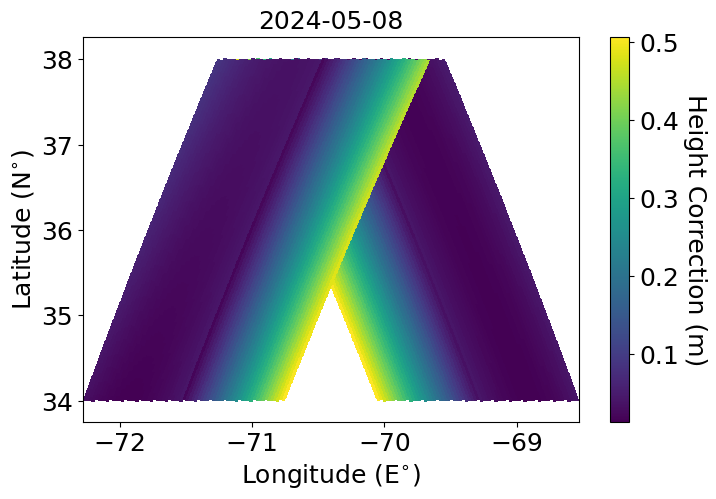

In [48]:
plt.clf()

fig,ax=plt.subplots(figsize=(8,5))
plot = ax.pcolormesh(ds1_masked.longitude-360,ds1_masked.latitude,ds1_masked.height_cor_xover)
plot = ax.pcolormesh(ds2_masked.longitude-360,ds2_masked.latitude,ds2_masked.height_cor_xover)

cbar = plt.colorbar(plot,ax=ax)

cbar.set_label('Height Correction (m)', rotation=270, labelpad=20)

ax.set_ylabel('Latitude (N$^{\circ}$)')
ax.set_xlabel('Longitude (E$^{\circ}$)')
ax.set_title('%s-%s-%s'%(date_requested[0:4],date_requested[4:6],date_requested[6:8]))

plt.show()

SSHA Karin 2 is the best quality to show the eddy

<Figure size 640x480 with 0 Axes>

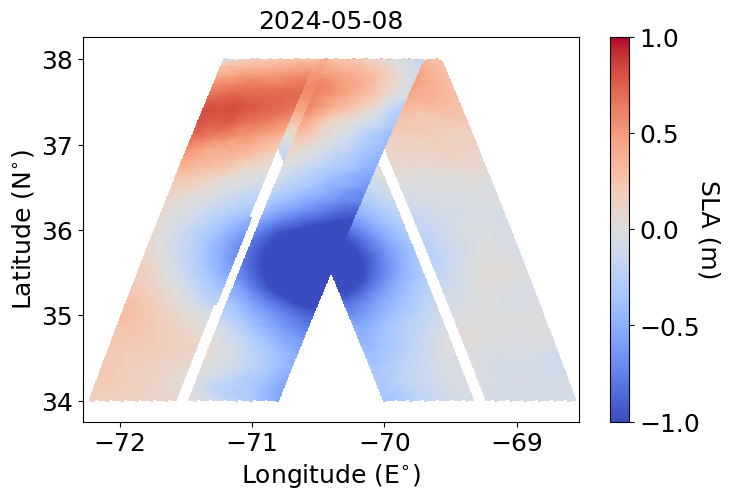

In [49]:
plt.clf()

fig,ax=plt.subplots(figsize=(8,5))
plot = ax.pcolormesh(ds1_masked.longitude-360,ds1_masked.latitude,ds1_masked.ssha_karin_2,cmap='coolwarm',vmin=-1,vmax=1)
plot = ax.pcolormesh(ds2_masked.longitude-360,ds2_masked.latitude,ds2_masked.ssha_karin_2,cmap='coolwarm',vmin=-1,vmax=1)

#plot = ax.pcolormesh(ds2_masked.longitude-360,ds2_masked.latitude,np.add(ds2_masked.ssha_karin_2,ds2_masked.height_cor_xover),cmap='coolwarm',vmin=-1,vmax=1)
cbar = plt.colorbar(plot,ax=ax)

cbar.set_label('SLA (m)', rotation=270, labelpad=15)

ax.set_ylabel('Latitude (N$^{\circ}$)')
ax.set_xlabel('Longitude (E$^{\circ}$)')
ax.set_title('%s-%s-%s'%(date_requested[0:4],date_requested[4:6],date_requested[6:8]))

plt.show()

Plot overlap

<Figure size 640x480 with 0 Axes>

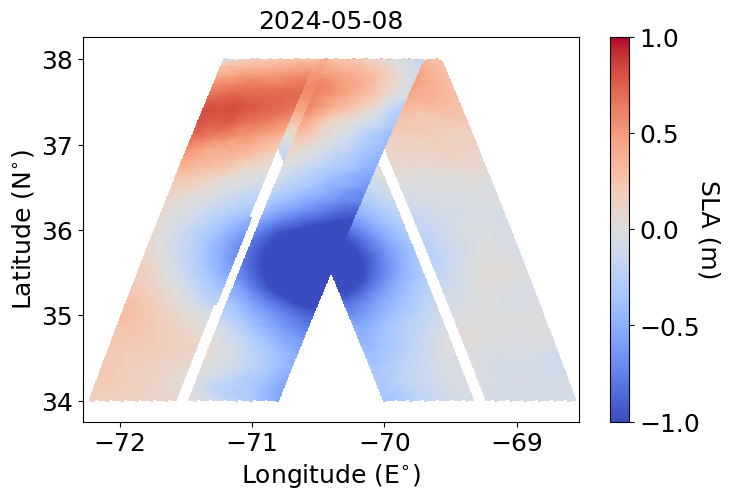

In [50]:
plt.clf()

fig,ax=plt.subplots(figsize=(8,5))
plot = ax.pcolormesh(ds1_masked.longitude-360,ds1_masked.latitude,ds1_masked.ssha_karin_2,cmap='coolwarm',vmin=-1,vmax=1)
plot = ax.pcolormesh(ds2_masked.longitude-360,ds2_masked.latitude,ds2_masked.ssha_karin_2,cmap='coolwarm',vmin=-1,vmax=1)

#plot = ax.pcolormesh(ds2_masked.longitude-360,ds2_masked.latitude,np.add(ds2_masked.ssha_karin_2,ds2_masked.height_cor_xover),cmap='coolwarm',vmin=-1,vmax=1)
cbar = plt.colorbar(plot,ax=ax)

cbar.set_label('SLA (m)', rotation=270, labelpad=15)

ax.set_ylabel('Latitude (N$^{\circ}$)')
ax.set_xlabel('Longitude (E$^{\circ}$)')
ax.set_title('%s-%s-%s'%(date_requested[0:4],date_requested[4:6],date_requested[6:8]))

plt.show()

Regrid SWOT data to regular grid. Need to do this before taking spatial gradients for velocity calculations.

In [17]:
xv = np.arange(287, 293, 0.036)
yv = np.arange(33,39, 0.036)
grid_x, grid_y = np.meshgrid(xv, yv)
ssh=ds1_masked.ssha_karin_2+ds1_masked.height_cor_xover
lat=ds1_masked.latitude
lon=ds1_masked.longitude
grid_ssh1 = griddata((lon.values.ravel(),lat.values.ravel()), ssh.values.ravel(), (grid_x, grid_y), method='linear')
ssh=ds2_masked.ssha_karin_2+ds2_masked.height_cor_xover
lat=ds2_masked.latitude
lon=ds2_masked.longitude
grid_ssh2 = griddata((lon.values.ravel(),lat.values.ravel()), ssh.values.ravel(), (grid_x, grid_y), method='linear')

Plot regridded SSH

<Figure size 640x480 with 0 Axes>

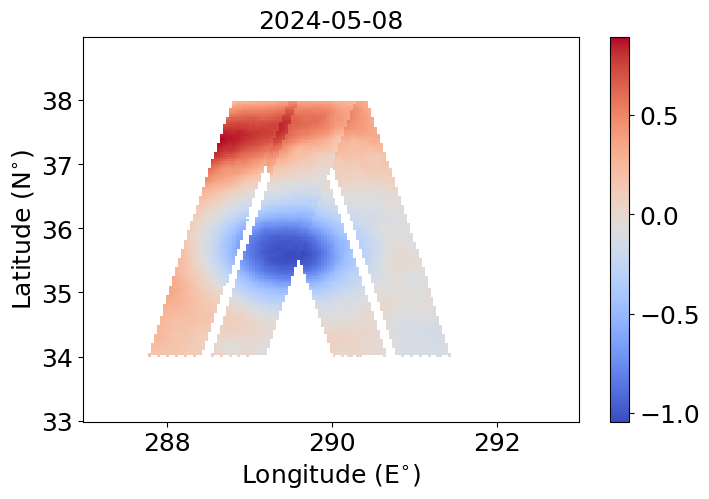

In [51]:
plt.clf()

fig,ax=plt.subplots(figsize=(8,5))
plot = ax.pcolormesh(grid_x,grid_y,grid_ssh1,cmap='coolwarm')
plot = ax.pcolormesh(grid_x,grid_y,grid_ssh2,cmap='coolwarm')
cbar = plt.colorbar(plot,ax=ax)

# cbar.set_label('dsdx', rotation=270, labelpad=15)

ax.set_ylabel('Latitude (N$^{\circ}$)')
ax.set_xlabel('Longitude (E$^{\circ}$)')
ax.set_title('%s-%s-%s'%(date_requested[0:4],date_requested[4:6],date_requested[6:8]))


plt.show()

In [19]:
def compute_geos_current(ssh,lat):
    """
    ssh: (m) Make sure this is first corrected with height_cor_xover from L2 data! 
    lat: degrees N
    """
    
    omega = 7.2921159e-05  # angular velocity of the Earth [rad/s]
    fc = 2*omega*np.sin(lat*np.pi/180.)
        
    # avoid zero near equator, bound fc by min val as 1.e-8
    f_coriolis = np.sign(fc)*np.maximum(np.abs(fc), 1.e-8)
    
    dx,dy = 4000,4000 # m i changed it to 4000 to match res? need to double check
    gravity = 9.81

    dsdy,dsdx=np.array(np.gradient(ssh, dx, edge_order=1))
    vg = (gravity/np.array(f_coriolis))*dsdx
    ug = -(gravity/np.array(f_coriolis))*dsdy
    geos_current = np.sqrt(ug**2 + vg**2)
    
    return ug,vg,geos_current

Compute geostrophic currents

In [20]:
#Calculate
ug1,vg1,geos_current1 = compute_geos_current(grid_ssh1,grid_y)
ug2,vg2,geos_current2 = compute_geos_current(grid_ssh2,grid_y)

<Figure size 640x480 with 0 Axes>

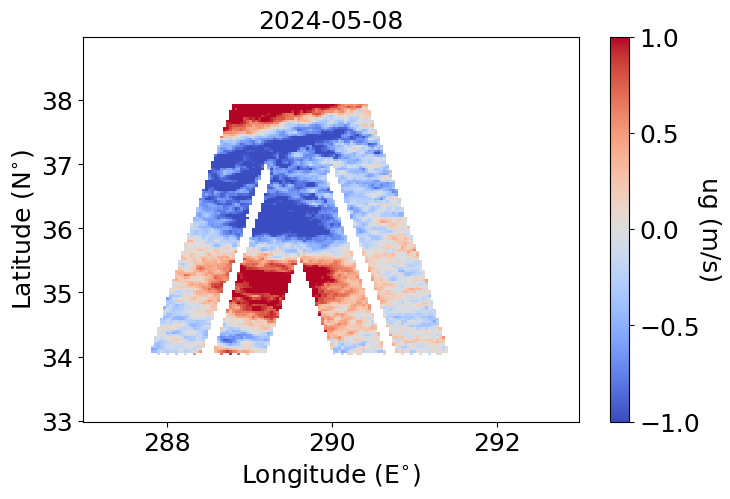

<Figure size 640x480 with 0 Axes>

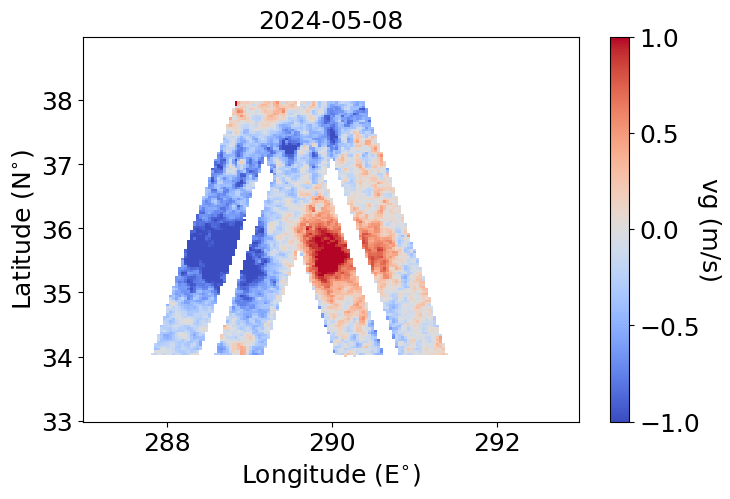

In [53]:
plt.clf()

fig,ax=plt.subplots(figsize=(8,5))
plot = ax.pcolormesh(grid_x,grid_y,ug1,cmap='coolwarm',vmin=-1,vmax=1)
plot = ax.pcolormesh(grid_x,grid_y,ug2,cmap='coolwarm',vmin=-1,vmax=1)
cbar = plt.colorbar(plot,ax=ax)

cbar.set_label('ug (m/s)', rotation=270, labelpad=15)

ax.set_ylabel('Latitude (N$^{\circ}$)')
ax.set_xlabel('Longitude (E$^{\circ}$)')
ax.set_title('%s-%s-%s'%(date_requested[0:4],date_requested[4:6],date_requested[6:8]))

plt.show()

plt.clf()

fig,ax=plt.subplots(figsize=(8,5))
plot = ax.pcolormesh(grid_x,grid_y,vg1,cmap='coolwarm',vmin=-1,vmax=1)
plot = ax.pcolormesh(grid_x,grid_y,vg2,cmap='coolwarm',vmin=-1,vmax=1)

cbar = plt.colorbar(plot,ax=ax)

cbar.set_label('vg (m/s)', rotation=270, labelpad=15)

ax.set_ylabel('Latitude (N$^{\circ}$)')
ax.set_xlabel('Longitude (E$^{\circ}$)')
ax.set_title('%s-%s-%s'%(date_requested[0:4],date_requested[4:6],date_requested[6:8]))

plt.show()

In [54]:
def compute_relative_vorticity(ug, vg, lat):
    omega = 7.2921159e-05  # angular velocity of the Earth [rad/s]
    fc = 2*omega*np.sin(lat*np.pi/180.)
    # avoid zero near equator, bound fc by min val as 1.e-8
    f_coriolis = np.sign(fc)*np.maximum(np.abs(fc), 1.e-8)
    
    dx,dy = 4000, 4000 # m
    du_dy, du_dx = np.gradient(ug, dx, edge_order=2)
    dv_dy, dv_dx = np.gradient(vg, dx, edge_order=2)
        
    ksi = (dv_dx - du_dy)/f_coriolis
        
    return ksi

Compute geostrophic vorticity. Smoothing is in the x,y direction, not along track, which is why the swath shrinks. Future problem to fix to increase swath of vorticity

In [55]:
wfl=5
ug_smooth1=xr.apply_ufunc(generic_filter,ug1, np.mean, [wfl,wfl])
vg_smooth1=xr.apply_ufunc(generic_filter,vg1, np.mean, [wfl,wfl])
ug_smooth2=xr.apply_ufunc(generic_filter,ug2, np.mean, [wfl,wfl])
vg_smooth2=xr.apply_ufunc(generic_filter,vg2, np.mean, [wfl,wfl])
ksi1=compute_relative_vorticity(ug_smooth1, vg_smooth1, grid_y)
ksi2=compute_relative_vorticity(ug_smooth2, vg_smooth2, grid_y)

<Figure size 640x480 with 0 Axes>

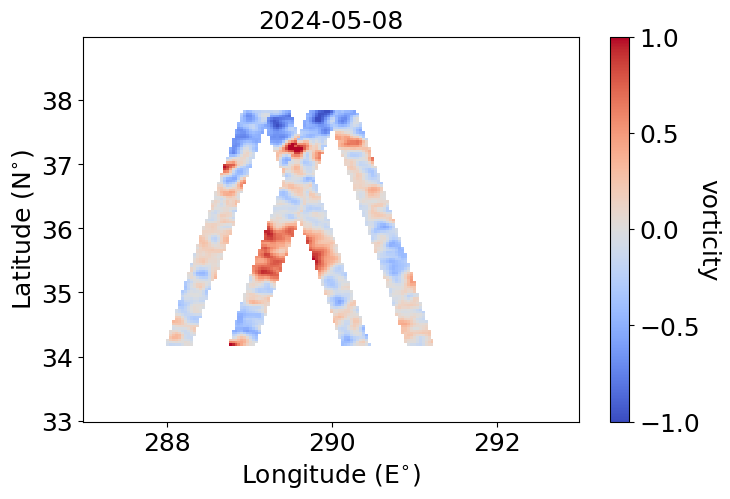

In [56]:
plt.clf()

fig,ax=plt.subplots(figsize=(8,5))
plot = ax.pcolormesh(grid_x,grid_y,ksi1,cmap='coolwarm',vmin=-1,vmax=1)
plot = ax.pcolormesh(grid_x,grid_y,ksi2,cmap='coolwarm',vmin=-1,vmax=1)

cbar = plt.colorbar(plot,ax=ax)

cbar.set_label('vorticity', rotation=270, labelpad=15)

ax.set_ylabel('Latitude (N$^{\circ}$)')
ax.set_xlabel('Longitude (E$^{\circ}$)')
ax.set_title('%s-%s-%s'%(date_requested[0:4],date_requested[4:6],date_requested[6:8]))

plt.show()

<Figure size 640x480 with 0 Axes>

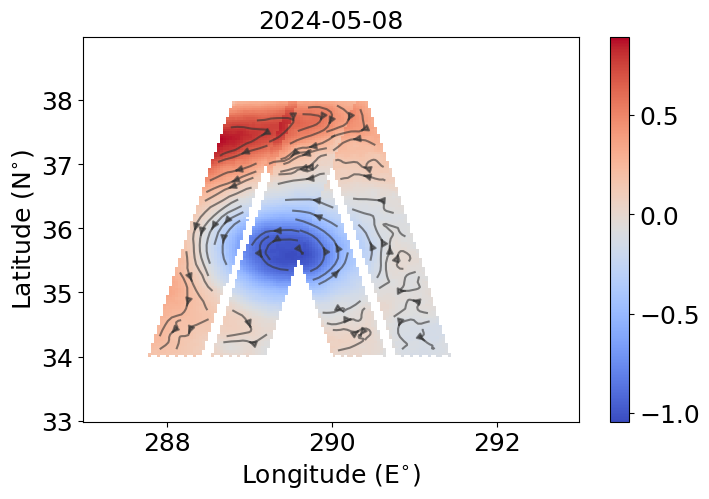

In [57]:
plt.clf()

fig,ax=plt.subplots(figsize=(8,5))
plot = ax.pcolormesh(grid_x,grid_y,grid_ssh1,cmap='coolwarm')
plot = ax.pcolormesh(grid_x,grid_y,grid_ssh2,cmap='coolwarm')
cbar = plt.colorbar(plot,ax=ax)
plt.streamplot(grid_x,grid_y,ug1,vg1, density = 2, color = (0.2,0.2,0.2,0.6))
plt.streamplot(grid_x,grid_y,ug2,vg2, density = 2, color = (0.2,0.2,0.2,0.6))

ax.set_ylabel('Latitude (N$^{\circ}$)')
ax.set_xlabel('Longitude (E$^{\circ}$)')
ax.set_title('%s-%s-%s'%(date_requested[0:4],date_requested[4:6],date_requested[6:8]))

plt.show()

### Load in PACE Data

In [58]:
results = earthaccess.search_datasets(instrument="oci")

tspan = ("2024-05-08", "2024-05-08")
#bbox = (-58, 37.5, -52, 41) #howie
bbox = (-73, 35, -70, 37) #edward
# bbox=(-61, 34, -59, 39) #patrick
clouds = (0, 100)
results = earthaccess.search_data(
    short_name="PACE_OCI_L2_BGC_NRT",
    temporal=tspan,
    bounding_box=bbox,
    cloud_cover=clouds,
)

paths = earthaccess.open(results) #'streaming' data

datatree = open_datatree(paths[0])
datatree
dataset = xr.merge(datatree.to_dict().values())
dataset
dataset = dataset.set_coords(("longitude", "latitude"))

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

In [25]:
h=str(paths[0])
datey=h[64:72]

### Load eddy data from AVISO

Using these contours to plot contour on top of chl & define in versus out of the eddy.

In [26]:
aviso_ds = xr.open_dataset('Edward_Eddy_trajectory_nrt_3.2exp_cyclonic_20180101_20240723.nc')
aviso_ds

<xarray.Dataset> Size: 202kB
Dimensions:                        (obs: 223, NbSample: 20)
Dimensions without coordinates: obs, NbSample
Data variables: (12/27)
    amplitude                      (obs) float64 2kB ...
    effective_area                 (obs) float32 892B ...
    effective_contour_height       (obs) float32 892B ...
    effective_contour_latitude     (obs, NbSample) float64 36kB ...
    effective_contour_longitude    (obs, NbSample) float64 36kB ...
    effective_contour_shape_error  (obs) float64 2kB ...
    ...                             ...
    speed_contour_longitude        (obs, NbSample) float64 36kB ...
    speed_contour_shape_error      (obs) float64 2kB ...
    speed_radius                   (obs) float64 2kB ...
    time                           (obs) datetime64[ns] 2kB ...
    track                          (obs) uint32 892B ...
    uavg_profile                   (obs, NbSample) float64 36kB ...
Attributes: (12/19)
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    comment:                   Surface product; mesoscale eddies
    creator_email:             aviso@altimetry.fr
    creator_url:               https://www.aviso.altimetry.fr
    date_created:              2024-08-06T09:38:06Z
    framework_used:            https://github.com/AntSimi/py-eddy-tracker
    ...                        ...
    standard_name_vocabulary:  NetCDF Climate and Forecast (CF) Metadata Conv...
    summary:                   This dataset contains eddy atlas from all-sate...
    time_coverage_duration:    P2396D
    time_coverage_end:         2024-07-23T00:00:00Z
    time_coverage_start:       2018-01-01T00:00:00Z
    title:                     Mesoscale Cyclonic Eddies in Altimeter Observa...

In [27]:
def get_eddy_by_ID_date(ds,eddy_date):
    """
    ds: netCDF AVISO format
    track_id: id of eddy to extract
    eddy_date: date in format 'YYYY-MM-DD'

    Returns contour lons, contour lats, center lon, center lat
    """
    try:
        ind = np.where(ds.time == np.datetime64(eddy_date))[0][0]
        contour_lons = np.array(ds.effective_contour_longitude[ind])
        contour_lats = np.array(ds.effective_contour_latitude[ind])
    except:
        print('No eddy data available with that request ... :(')        
    
    return contour_lons,contour_lats,ds.longitude[ind],ds.latitude[ind]

In [28]:
contour_lons,contour_lats,center_lon,center_lat = get_eddy_by_ID_date(aviso_ds,'2024-05-08')

Text(0.5, 1.0, '2024-05-08')

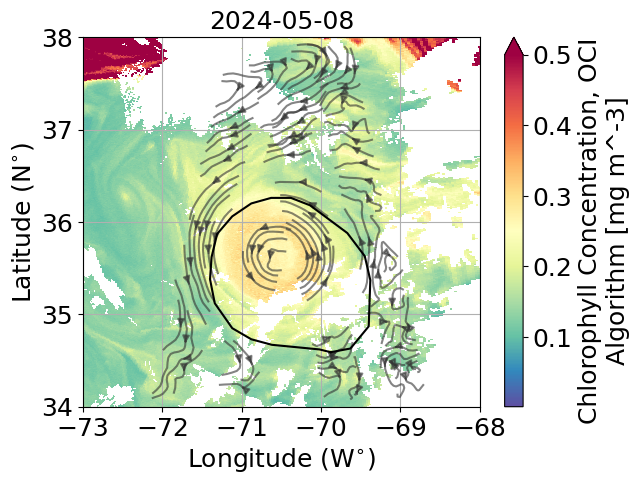

In [59]:
grid_x_180 = grid_x - 360 #only works for >180˚

fig = plt.figure()
ax = plt.axes()
plot=dataset["chlor_a"].plot(x="longitude", y="latitude", cmap="Spectral_r", vmax=0.5, ax=ax) #tried adding ,transform=ccrs.PlateCarree()
ax.grid(True)
ax.streamplot(grid_x_180,grid_y,ug1,vg1, density = 3, color = (0.2,0.2,0.2,0.6))
ax.streamplot(grid_x_180,grid_y,ug2,vg2, density = 3, color = (0.2,0.2,0.2,0.6))

ax.plot(contour_lons-360,contour_lats,zorder=100,c='k')

ax.set_ylabel('Latitude (N$^{\circ}$)')
ax.set_xlabel('Longitude (E$^{\circ}$)')
ax.set_title('%s-%s-%s'%(date_requested[0:4],date_requested[4:6],date_requested[6:8]))

ax.set_ylim([34,38])
ax.set_xlim([-73,-68])

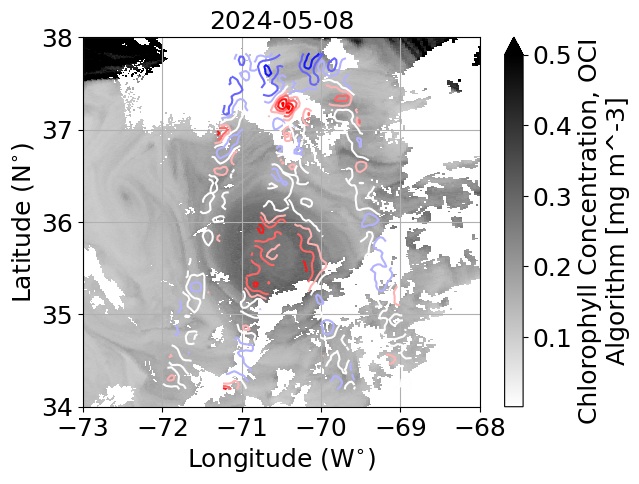

In [62]:
fig = plt.figure()
ax = plt.axes()
plot=dataset["chlor_a"].plot(x="longitude", y="latitude", cmap="binary", vmax=0.5, ax=ax) #tried adding ,transform=ccrs.PlateCarree()
ax.grid(True)
ax.contour(grid_x_180,grid_y,ksi1,cmap='bwr',vmin=-1,vmax=1)
ax.contour(grid_x_180,grid_y,ksi2,cmap='bwr',vmin=-1,vmax=1)
ax.set_ylabel('Latitude (N$^{\circ}$)')
ax.set_xlabel('Longitude (E$^{\circ}$)')
ax.set_title('%s-%s-%s'%(date_requested[0:4],date_requested[4:6],date_requested[6:8]))

ax.set_ylim([34,38])
ax.set_xlim([-73,-68])

plt.show()

## Zoom out 

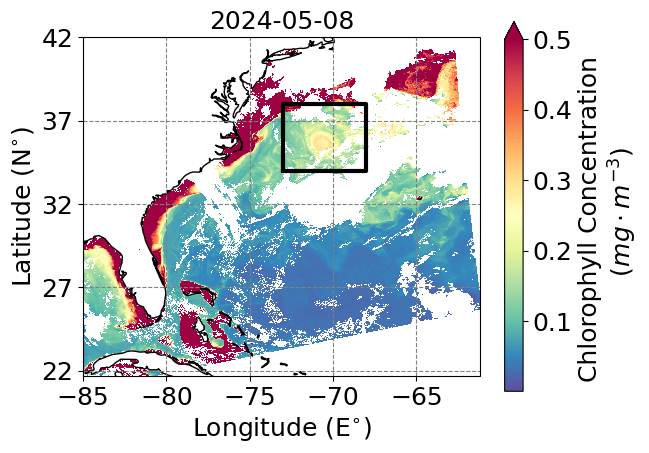

In [64]:
fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
plot=dataset["chlor_a"].plot(x="longitude", y="latitude", cmap="Spectral_r", vmax=0.5, ax=ax) #tried adding ,transform=ccrs.PlateCarree()
plt.plot([-73,-68,-68,-73,-73],[34,34,38,38,34],c='k',lw=3,transform=ccrs.PlateCarree())
ax.grid(True)
ax.axis("scaled")
ax.set_ylabel('latitude')
ax.set_xlabel('longitude')
ax.set_ylim([21.7,42])
ax.set_xlim([-85,-61.2])

# Set gridlines with labels
ax.grid(True, linestyle='--', color='gray')

# Set latitude and longitude labels
ax.set_ylabel('Latitude (N$^{\circ}$)')
ax.set_xlabel('Longitude (E$^{\circ}$)')
ax.set_title('%s-%s-%s'%(date_requested[0:4],date_requested[4:6],date_requested[6:8]))

# Customize tick marks for latitude and longitude
ax.set_xticks(range(-85, -60, 5))  # Longitude ticks from -85 to -60 with a step of 5
ax.set_yticks(range(22, 43, 5))    # Latitude ticks from 22 to 42 with a step of 5

# Modify the colorbar
cbar = plot.colorbar
cbar.set_label('Chlorophyll Concentration \n ($mg\cdot m^{-3}$)')

### MOANA

In [66]:
moana_ds = xr.open_dataset('/home/jovyan/GO-SWACE/moana_dataset_merged.nc') # should rename this with file extention .nc
lon = moana_ds.variables['longitude'] 
lat = moana_ds.variables['latitude'] 
pro = moana_ds.variables['prococcus_moana']
pico = moana_ds.variables['picoeuk_moana'] 
syn = moana_ds.variables['syncoccus_moana'] 

/tmp/ipykernel_609/2274726130.py:4: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot=ax.pcolormesh(lon,lat,pro,cmap='YlGnBu_r',vmax=400000)


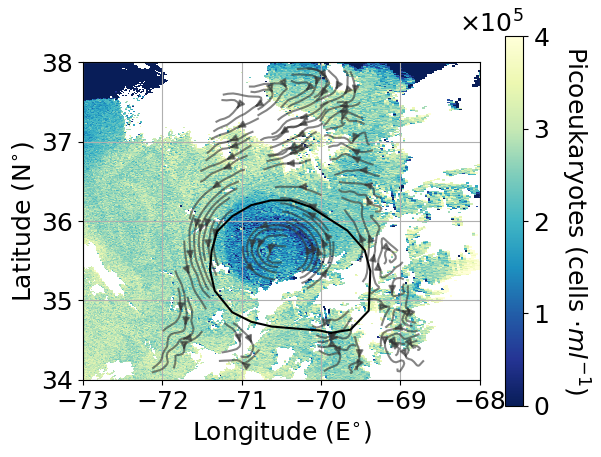

In [67]:
fig.clf()
fig = plt.figure()
ax = plt.axes()
plot=ax.pcolormesh(lon,lat,pro,cmap='YlGnBu_r',vmax=400000)
ax.streamplot(grid_x_180,grid_y,ug1,vg1, density = 3, color = (0.2,0.2,0.2,0.6))
ax.streamplot(grid_x_180,grid_y,ug2,vg2, density = 3, color = (0.2,0.2,0.2,0.6))

ax.plot(contour_lons-360,contour_lats,zorder=100,c='k')

ax.grid(True)
ax.set_ylim([34,38])
ax.set_xlim([-73,-68])
cbar = plt.colorbar(plot,ax=ax)
cbar.set_label('Picoeukaryotes (cells $ \cdot ml^{-1}$)', rotation=270, labelpad=30)
cbar.formatter.set_powerlimits((0, 0))
cbar.formatter.set_useMathText(True)

ax.set_ylabel('Latitude (N$^{\circ}$)')
ax.set_xlabel('Longitude (E$^{\circ}$)')
plt.show()

## Load NPP

In [68]:
npp=[]
with open("/home/jovyan/GO-SWACE/Edward_NPP.txt", "r") as csv_file:
    csv_reader = csv.reader(csv_file, delimiter='\t')
    count = 0
    for row in csv_reader:
        if count != 0: 
            temp_row = []
            for i in row:
                if i == 'NA':
                    temp_row.append(np.nan)
                else:
                    temp_row.append(float(i))
            npp.append(temp_row)
        count += 1

In [72]:
def read_lat_lon_NPP_arrays(filename):
    npp_array=[]
    with open(filename, "r") as csv_file:
        csv_reader = csv.reader(csv_file, delimiter='\t')
        count = 0
        for row in csv_reader:
            if count == 0: # skip header
                pass
            else:
                npp_array.append(float(row[0]))
            count += 1
    return npp_array

In [73]:
npp_lat = read_lat_lon_NPP_arrays("/home/jovyan/GO-SWACE/Edward_NPP_lat.txt")
npp_lon = read_lat_lon_NPP_arrays("/home/jovyan/GO-SWACE/Edward_NPP_lon.txt")
print(np.shape(npp_lat))
print(np.shape(npp_lon))
print(np.shape(npp))

(60,)
(70,)
(70, 60)


Need to transpose npp so that it is (lat,lon) format like the rest of the data.

In [74]:
npp = np.transpose(npp)
print(np.shape(npp))

(60, 70)


/tmp/ipykernel_609/396243647.py:5: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot=ax[0,0].pcolormesh(dataset["longitude"],dataset["latitude"],dataset["chlor_a"],cmap='Spectral_r',vmax=0.35)
/tmp/ipykernel_609/396243647.py:20: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot=ax[1,0].pcolormesh(lon,lat,np.divide(pro,syn),cmap='YlGnBu',vmax=1.25*(10**2))
/tmp/ipykernel_609/396243647.py:27: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in whi

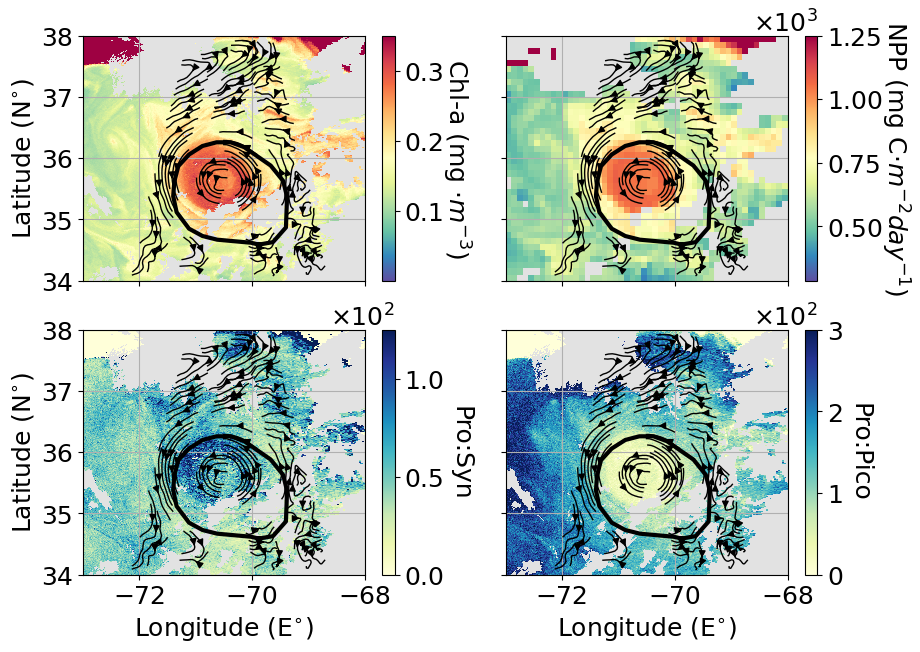

In [78]:
fig.clf()
fig,ax=plt.subplots(2,2,figsize=(10,7))

# CHLA #
plot=ax[0,0].pcolormesh(dataset["longitude"],dataset["latitude"],dataset["chlor_a"],cmap='Spectral_r',vmax=0.35)
cbar = plt.colorbar(plot,ax=ax[0,0])
cbar.set_label('Chl-a (mg $ \cdot m^{-3}$)', rotation=270, labelpad=20)
ax[0,0].set_xticklabels([])

# NPP #
plot=ax[0,1].pcolormesh(npp_lon,npp_lat,npp,cmap='Spectral_r',vmax=1250)
cbar = plt.colorbar(plot,ax=ax[0,1])
cbar.set_label('NPP (mg C$\cdot m^{-2}day^{-1}$)', rotation=270, labelpad=20)
cbar.formatter.set_powerlimits((0, 0))
cbar.formatter.set_useMathText(True)
ax[0,1].set_xticklabels([])
ax[0,1].set_yticklabels([])

# Pro:Syn #
plot=ax[1,0].pcolormesh(lon,lat,np.divide(pro,syn),cmap='YlGnBu',vmax=1.25*(10**2))
cbar = plt.colorbar(plot,ax=ax[1,0])
cbar.set_label('Pro:Syn', rotation=270, labelpad=20)
cbar.formatter.set_powerlimits((0, 0))
cbar.formatter.set_useMathText(True)

# Pro:Pico #
plot=ax[1,1].pcolormesh(lon,lat,np.divide(pro,pico),cmap='YlGnBu',vmax=3*(10**2))
cbar = plt.colorbar(plot,ax=ax[1,1])
cbar.set_label('Pro:Pico', rotation=270, labelpad=20)
cbar.formatter.set_powerlimits((0, 0))
cbar.formatter.set_useMathText(True)
ax[1,1].set_yticklabels([])

for r in [0,1]:    
    for c in [0,1]:
        ax[r,c].streamplot(grid_x_180,grid_y,ug1,vg1, density = 3, color = 'k',linewidth=1)
        ax[r,c].streamplot(grid_x_180,grid_y,ug2,vg2, density = 3, color = 'k',linewidth=1)
        ax[r,c].plot(contour_lons-360,contour_lats,zorder=100,c='k',linewidth=3)
        ax[r,c].set_ylim([34,38])
        ax[r,c].set_xlim([-73,-68])
        ax[r,c].grid(True)
        ax[r,c].set_facecolor('#e2e2e2')
        
        if c == 0:
            ax[r,c].set_ylabel('Latitude (N$^{\circ}$)')
        if r == 1:
            ax[r,c].set_xlabel('Longitude (E$^{\circ}$)')

plt.show()

### Add in low-res altimeter data (OSCAR)

In [75]:
results = earthaccess.search_datasets(keyword="oscar")
for item in results[:6]: # subsetted to show the first couple of results because this is erroring for some reason
    summary = item.summary()
    print(summary["short-name"])

OSCAR_L4_OC_INTERIM_V2.0
OSCAR_L4_OC_NRT_V2.0
OSCAR_L4_OC_third-deg
OSCAR_L4_OC_1deg
OSCAR_L4_OC_third-deg_YEARLY
OSCAR_L4_OC_FINAL_V2.0


In [76]:
bbox = (lonmin, latmin, lonmax, latmax) # lonW, latS, lonE, latN
results = earthaccess.search_data(
        short_name="OSCAR_L4_OC_NRT_V2.0",
        bounding_box=bbox,
        temporal=(tmin,tmax))
    
print("Number of swaths: " + str(len(results))) # not daily files, so will likely be more than # of days
oscar_paths = earthaccess.open(results) # is there a way to choose a subset of variables here?

Number of swaths: 125


QUEUEING TASKS | :   0%|          | 0/125 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/125 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/125 [00:00<?, ?it/s]

In [77]:
dates_available = []
for i in oscar_paths:
    today = str(i).split('.')[-2].split('_')[-1]
    if today not in dates_available:
        dates_available.append(today)
print(dates_available)

['20240403', '20240404', '20240405', '20240406', '20240407', '20240408', '20240409', '20240410', '20240411', '20240412', '20240413', '20240414', '20240415', '20240416', '20240417', '20240418', '20240419', '20240420', '20240421', '20240422', '20240423', '20240424', '20240425', '20240426', '20240427', '20240428', '20240429', '20240430', '20240501', '20240502', '20240503', '20240504', '20240505', '20240506', '20240507', '20240508', '20240509', '20240510', '20240511', '20240512', '20240513', '20240514', '20240515', '20240516', '20240517', '20240518', '20240519', '20240520', '20240521', '20240522', '20240523', '20240524', '20240525', '20240526', '20240527', '20240528', '20240529', '20240530', '20240531', '20240601', '20240602', '20240603', '20240604', '20240605', '20240606', '20240607', '20240608', '20240609', '20240610', '20240611', '20240612', '20240613', '20240614', '20240615', '20240616', '20240617', '20240618', '20240619', '20240620', '20240621', '20240622', '20240623', '20240624', '20

In [39]:
date_requested = '20240508'

ind = 0 
for i in oscar_paths:
    today = str(i).split('.')[-2].split('_')[-1]
    if date_requested == today:
        print(ind)
    ind += 1

35


In [40]:
print(oscar_paths[35])

<File-like object S3FileSystem, podaac-ops-cumulus-protected/OSCAR_L4_OC_NRT_V2.0/oscar_currents_nrt_20240508.nc>


In [41]:
oscar_ds = xr.open_dataset(oscar_paths[35])
oscar_ds = oscar_ds.transpose("time", "latitude", "longitude") # oscar reads in stupid, so just do this line.. trust me ;)
oscar_ds

<xarray.Dataset> Size: 33MB
Dimensions:  (latitude: 719, longitude: 1440, time: 1)
Coordinates:
    lat      (latitude) float64 6kB ...
    lon      (longitude) float64 12kB ...
  * time     (time) object 8B 2024-05-08 00:00:00
Dimensions without coordinates: latitude, longitude
Data variables:
    u        (time, latitude, longitude) float64 8MB ...
    v        (time, latitude, longitude) float64 8MB ...
    ug       (time, latitude, longitude) float64 8MB ...
    vg       (time, latitude, longitude) float64 8MB ...
Attributes: (12/36)
    title:                      Ocean Surface Current Analyses Real-time (OSC...
    summary:                    Global, daily, 0.25 degree geostrophic and to...
    keywords:                   ocean currents,ocean circulation,surface curr...
    Conventions:                CF-1.8 Standard Names v77, ACDD-1.3, netcdf 4...
    id:                         OSCAR_L4_OC_NRT_V2.0
    history:                    OSCAR 0.25 degree daily version 2.0 replaces ...
    ...                         ...
    geospatial_lon_max:         359.75
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.25 degree
    time_coverage_start:        2024-05-08T00:00:00
    time_coverage_end:          2024-05-08T23:59:59
    date_created:               2024-07-08

In [42]:
def crop_oscar_by_lat_lon(ds,latmin,latmax,lonmin,lonmax):
    mask = (ds.lat >= latmin) & (ds.lat <= latmax) & (ds.lon >= lonmin+360) & (ds.lon <= lonmax+360)
    ds_masked = ds.where(mask, drop=True)
    return ds_masked

In [43]:
oscar_ds_masked = crop_oscar_by_lat_lon(oscar_ds,latmin,latmax,lonmin,lonmax)
oscar_ds_masked

<xarray.Dataset> Size: 12kB
Dimensions:  (time: 1, latitude: 17, longitude: 21)
Coordinates:
    lat      (latitude) float64 136B 34.0 34.25 34.5 34.75 ... 37.5 37.75 38.0
    lon      (longitude) float64 168B 287.0 287.2 287.5 ... 291.5 291.8 292.0
  * time     (time) object 8B 2024-05-08 00:00:00
Dimensions without coordinates: latitude, longitude
Data variables:
    u        (time, latitude, longitude) float64 3kB 0.4162 0.2321 ... 0.2159
    v        (time, latitude, longitude) float64 3kB -0.2337 0.02422 ... 0.6781
    ug       (time, latitude, longitude) float64 3kB 0.4092 0.2235 ... 0.2712
    vg       (time, latitude, longitude) float64 3kB -0.222 0.04015 ... 0.7351
Attributes: (12/36)
    title:                      Ocean Surface Current Analyses Real-time (OSC...
    summary:                    Global, daily, 0.25 degree geostrophic and to...
    keywords:                   ocean currents,ocean circulation,surface curr...
    Conventions:                CF-1.8 Standard Names v77, ACDD-1.3, netcdf 4...
    id:                         OSCAR_L4_OC_NRT_V2.0
    history:                    OSCAR 0.25 degree daily version 2.0 replaces ...
    ...                         ...
    geospatial_lon_max:         359.75
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.25 degree
    time_coverage_start:        2024-05-08T00:00:00
    time_coverage_end:          2024-05-08T23:59:59
    date_created:               2024-07-08

Each of the layers could be commented out as preferred (as in the presentation)

<Figure size 640x480 with 0 Axes>

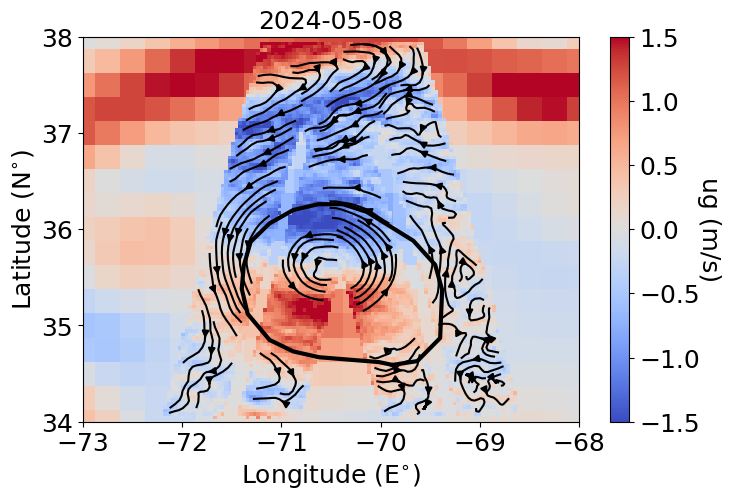

In [80]:
plt.clf()

magnitude = 1.5

fig,ax=plt.subplots(figsize=(8,5))

# LOW RES VELOCITY
plot = ax.pcolormesh(oscar_ds_masked.lon-360,oscar_ds_masked.lat,oscar_ds_masked.ug[0],cmap='coolwarm',vmin=-magnitude,vmax=magnitude)

# SWOT SWATHS OF VELOCITY
ax.pcolormesh(grid_x-360,grid_y,ug1,cmap='coolwarm',vmin=-magnitude,vmax=magnitude)
ax.pcolormesh(grid_x-360,grid_y,ug2,cmap='coolwarm',vmin=-magnitude,vmax=magnitude)

# STREAMLINES FROM SWOT
ax.streamplot(grid_x_180,grid_y,ug1,vg1, density = 3, color = 'k')
ax.streamplot(grid_x_180,grid_y,ug2,vg2, density = 3, color = 'k')

# EDDY CONTOUR
ax.plot(contour_lons-360,contour_lats,zorder=100,c='k',linewidth=3)

# PARAMS 
cbar = plt.colorbar(plot,ax=ax)
cbar.set_label('ug (m/s)', rotation=270, labelpad=15)

ax.set_title('%s-%s-%s'%(date_requested[0:4],date_requested[4:6],date_requested[6:8]))
ax.set_ylabel('Latitude (N$^{\circ}$)')
ax.set_xlabel('Longitude (E$^{\circ}$)')

ax.set_xlim([lonmin,lonmax])
ax.set_ylim([latmin,latmax ])

plt.show()